In [2]:
!pip -q install tensorflow=="2.4"
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools

     |████████████████████████████████| 394.7 MB 18 kB/s 
     |████████████████████████████████| 3.8 MB 37.6 MB/s 
     |████████████████████████████████| 462 kB 38.1 MB/s 
     |████████████████████████████████| 2.9 MB 31.4 MB/s 
     |████████████████████████████████| 591 kB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 28.5 MB/s 
     |████████████████████████████████| 1.1 MB 43.1 MB/s 
     |████████████████████████████████| 6.3 MB 26.4 MB/s 
     |████████████████████████████████| 840 kB 47.5 MB/s 
     |████████████████████████████████| 213 kB 48.0 MB/s 
     |████████████████████████████████| 120 kB 49.3 MB/s 
     |████████████████████████████████| 87 kB 6.0 MB/s 
     |████████████████████████████████| 103 kB 41.9 MB/s 
     |████████████████████████████████| 1.2 MB 40.8 MB/s 
     |████████████████████████████████| 596 kB 42.6 MB/s 
     |████████████████████████████████| 64 kB 2.7 MB/s 
     |████████████████████████████████| 207 kB 42.5 MB/s 
     |█████████████

In [3]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')
print(tf.__version__)

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

2.4.0


In [ ]:
!curl -L "https://app.roboflow.com/ds/MRtJOCvWpY?key=v5dj2YEsFa" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [130]:
!mkdir /content/test/images
!mkdir /content/test/annotations
!mkdir /content/train/images
!mkdir /content/train/annotations
!mkdir /content/valid/images
!mkdir /content/valid/annotations
!mv /content/test/*.jpg /content/test/images
!mv /content/test/*.xml /content/test/annotations
!mv /content/train/*.jpg /content/train/images
!mv /content/train/*.xml /content/train/annotations
!mv /content/valid/*.jpg /content/valid/images
!mv /content/valid/*.xml /content/valid/annotations

In [6]:
test_data = object_detector.DataLoader.from_pascal_voc(
    "/content/test/images",
    "/content/test/annotations",
    label_map={1: "masked", 2: "unmasked"}) 

In [38]:
import cv2

from PIL import Image

model_path = 'detect.tflite'

# Load the labels into a list
#classes = ['???'] * model.model_spec.config.num_classes
classes = ['???'] * 2
##label_map = model.model_spec.config.label_map
#for label_id, label_name in label_map.as_dict().items():
#  classes[label_id-1] = label_name

classes[0] = 'Masked'
classes[1] = 'Unmasked'
# Define a list of colors for visualization
# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  bbC = []
  scoreArr = []
  classLabels = []
  for obj in results:
    bb=[]
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])
    bb.append(xmin)
    bb.append(xmax)
    bb.append(ymin)
    bb.append(ymax)

    bbC.append(bb)
    scoreArr.append(obj['score'])
    classLabels.append(int(obj['class_id']))
    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8,bbC,scoreArr,classLabels

In [ ]:
DETECTION_THRESHOLD = 0.3

TEMP_FILE = '/content/test/images/real_01074_jpg.rf.e7ddcf096eb7f357fff020a74b479c5a.jpg'

#!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(TEMP_FILE)
#im.thumbnail((512, 512), Image.ANTIALIAS)
#im.save(TEMP_FILE, 'JPG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image,a,b,c = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)


In [10]:
# Funzione utilizzata per il calcolo dell'Intersection over Union (IoU)
def compute_iou(g_xmin,g_xmax,g_ymin,g_ymax, d_xmin,d_xmax,d_ymin,d_ymax):
   
    
    xa = max(g_xmin, d_xmin)
    ya = max(g_ymin, d_ymin)
    xb = min(g_xmax, d_xmax)
    yb = min(g_ymax, d_ymax)

    intersection = max(0, xb - xa + 1) * max(0, yb - ya + 1)

    boxAArea = (g_xmax - g_xmin + 1) * (g_ymax - g_ymin + 1)
    boxBArea = (d_xmax - d_xmin + 1) * (d_ymax - d_ymin + 1)

    return intersection / float(boxAArea + boxBArea - intersection)


In [131]:
# 0 ---> masked
# 1 ---> unmasked
# GROUNDTRUTH_BOX rappresentano i valori veri dei rettangoli di delimitazione
# label_truth contiene le classi delle immagini
groundtruth_box = [[104,262,40,368],[162,370,55,244],[49,348,34,365],
                   [172,346,33,381],[204,307,48,264],[56,352,29,327],[140,270,67,285],
                   [86,198,87,253],[200,378,75,252],[54,311,93,324],
                   [107,279,54,376],[10,278,91,341],[53,322,44,403],
                   [97,351,43,362],[68,325,96,387],[118,301,58,316],
                   [70,332,30,319],[106,274,46,298],[127,281,41,247],
                   [148,347,68,317],[97,322,23,310],[1,296,17,249],[108,326,50,350],
                   [157,302,55,307],[154,257,32,276],[81,224,94,264],[140,273,39,300],
                   [95,251,103,347],[31,371,33,416],[21,370,12,385],
                   [113,351,26,346],[64,363,28,288],[21,286,13,276],
                   [119,318,28,264],[66,373,16,380],[2,241,23,211],
                   [131,340,18,317],[101,308,19,246],[63,416,15,301],
                   [48,323,26,366],[33,319,65,416],[112,266,71,365],
                   [29,309,13,263],[56,366,23,369],[67,364,19,386],
                   [56,360,20,383],[100,307,35,355],[54,271,58,291],
                   [88,294,59,416],[8,315,22,416],[9,377,23,416],
                   [23,366,44,411],[13,388,47,408],[38,338,37,416],
                   [47,339,23,384],[79,328,39,397],[42,330,37,416],
                   [26,361,34,376],[48,337,48,401],[42,370,55,390],
                   [24,394,16,415],[23,378,51,400],[73,355,42,397],
                   [50,365,55,408],[35,342,36,426],[11,367,39,403],
                   [40,398,48,403],[42,334,39,402],[28,352,44,412],
                   [47,345,6,375],[49,353,29,407],[12,358,19,410],
                   [47,386,17,417],[54,340,56,406],[30,345,38,399],
                   [27,335,65,400],[61,384,55,413],[49,357,45,406],
                   [68,342,48,403],[51,321,78,396],[43,333,38,416],
                   [19,335,38,416],[44,331,69,395],[43,391,62,402],
                   [51,364,30,387],[14,362,32,416],[34,351,39,404],
                   [37,341,34,391],[26,393,48,387],[29,388,34,408],
                   [44,328,31,389],[38,365,17,387],[37,364,37,400],
                   [61,361,29,388],[37,346,35,410],[30,346,51,393],
                   [40,368,28,381],[52,389,30,416],[26,340,39,416],
                   [9,416,28,417]]
label_truth = [0,0,0,0,0,0,0,0,0,0,
               0,0,0,0,0,0,0,0,0,0,
               0,0,0,0,0,0,0,0,0,0,
               0,0,0,0,0,0,0,0,0,0,
               0,0,0,0,0,0,0,0,0,0,
               1,1,1,1,1,1,1,1,1,1,
               1,1,1,1,1,1,1,1,1,1,
               1,1,1,1,1,1,1,1,1,1,
               1,1,1,1,1,1,1,1,1,1,
               1,1,1,1,1,1,1,1,1,1
               ]



In [ ]:
# detection box trattiene le predizioni dei rettangolo
# scores rappresenta i valori dei punteggi assegnati ad ogni predizione
# label_pred trattiene le predizion delle classi
detection_box = [];
scores = [];
label_pred = [];
DETECTION_THRESHOLD = 0.3
import os

# Raccogli i dati iterando la cartella test
for filename in sorted(os.listdir('/content/test/images/')):
    print(filename)
    path = '/content/test/images/'+filename
    detection_result_image,bb,score,classL = run_odt_and_draw_results(
      path,
      interpreter,
      threshold=DETECTION_THRESHOLD)
    detection_box.append(bb)
    scores.append(score)
    label_pred.append(classL)

In [25]:
!mv /content/images/ /content/test/


In [179]:
# Non considero i Tn in quanto utilizzo immagini dove è sempre presente l'immagine di interesse
# Effettua il controllo per ogni singola immagine e la classifica come tp,fp,fn
THRESHOLD = 0.5
SCORETHRESOLD = 0.5
tp = 0;
fp = 0;
fn = 0;
tn = 0;
for i in range(100):
  lunghezza = range(len(detection_box[i]))
  
  for j in lunghezza:
    iOU = compute_iou(detection_box[i][j][0],detection_box[i][j][1],detection_box[i][j][2],detection_box[i][j][3],
                    groundtruth_box[i][0],groundtruth_box[i][1],groundtruth_box[i][2],groundtruth_box[i][3])
  
  if iOU > THRESHOLD and scores[i][0] > SCORETHRESOLD and label_pred[i][j] == label_truth[i]: 
      tp = tp + 1
  elif iOU > THRESHOLD and scores[i][0] > SCORETHRESOLD and label_pred[i][j] != label_truth[i]:
      fn = fn +1
  elif iOU < THRESHOLD:
      fp = fp +1
      k = i

In [181]:
print(tp)
print(fp)
print(fn)

98
1
1


In [160]:
# PARAMETRI PRESTAZIONALI
specificity = tn/(tn + fp)
sensitivity = tp/(tp + fn)
precision = tp/(tp + fp)

print('La specificità è: ', specificity)
print('La precisione è: ', precision)
print('La sensitività è: ' , sensitivity)


La specificità è:  0.0
La precisione è:  0.98989898989899
La sensitività è:  0.98989898989899


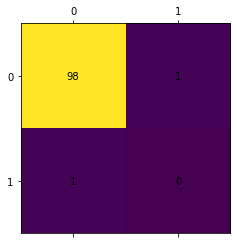

In [183]:
# MATRICE DI CONUSIONE
import numpy as np
import matplotlib.pyplot as plt



fig, ax = plt.subplots()
matrix = np.matrix([[98, 1],[1, 0]])
ax.matshow(matrix)


ax.text(0, 0, tp, va='center', ha='center')
ax.text(0, 1, fp, va='center', ha='center')
ax.text(1, 0, fn, va='center', ha='center')
ax.text(1, 1, tn, va='center', ha='center')

plt.show()

In [128]:
rm -r /content/train